# Open results file using Pandas

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SUBDIRECTORY = 'llm-img2txt'
FILENAME = 'nonorm_2025-07-07_15-50-20.csv'

root_dir = Path.cwd().parent.parent
results_csv_path = root_dir / 'benchmarking-results' / 'txt-accuracy' / SUBDIRECTORY / FILENAME

results = pd.read_csv(results_csv_path)
results = results.rename(columns={'Unnamed: 0': 'metric'})
results

,metric,gemini-2.5-flash,gpt-4o
0,kbaa-p003:dist_char,184.000000,41.000000
1,kbaa-p003:doc_len,2894.000000,2894.000000
2,kbaa-p003:cer_pct,6.357982,1.416724
3,kbaa-p003:wer_pct,36.809816,7.975460
4,kbaa-p003:token_sort_ratio,97.529967,97.864574
5,kbaa-p004:dist_char,36.000000,54.000000
6,kbaa-p004:doc_len,3757.000000,3757.000000
7,kbaa-p004:cer_pct,0.958211,1.437317
8,kbaa-p004:wer_pct,5.320814,7.824726
9,kbaa-p004:token_sort_ratio,99.637681,98.718306


In [21]:
# Create results without aggregated 
results_aggregate = results[results[results.columns[0]].str.contains(r'__ALL__', regex=True)]
results_individual = results.drop(results_aggregate.index, axis="index")

# Bar charts of aggregated results

(97.0, 100.0)

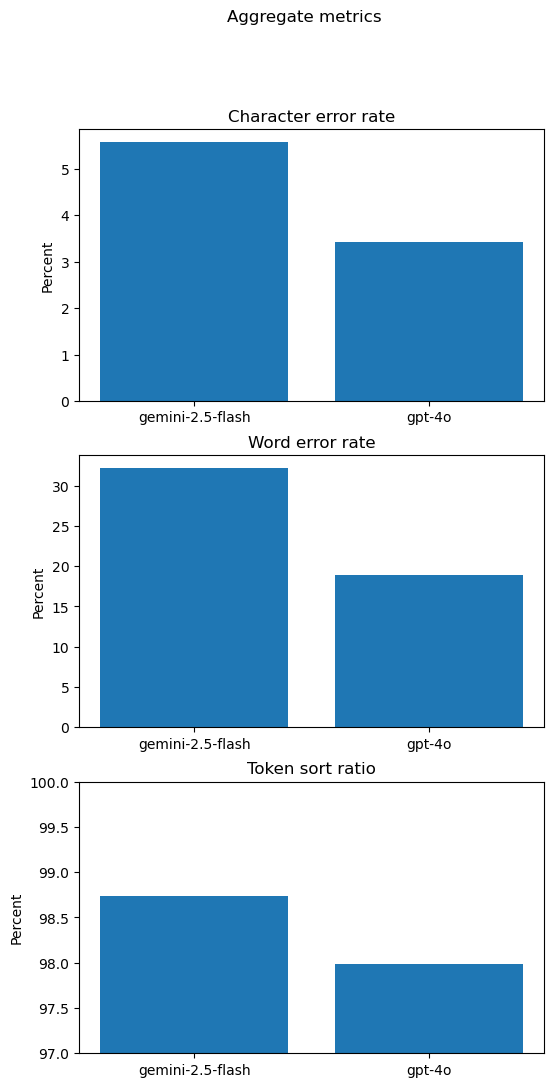

In [58]:
fig, (cer_ax, wer_ax, tsr_ax) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

cer_pct = results[results['metric'] == '__ALL__:cer_pct'].drop(columns='metric')
wer_pct = results[results['metric'] == '__ALL__:wer_pct'].drop(columns='metric')
token_sort_ratio = results[results['metric'] == '__ALL__:token_sort_ratio'].drop(columns='metric')
models = cer_pct.columns

fig.suptitle('Aggregate metrics')

cer_ax.bar(models, cer_pct.iloc[0])
cer_ax.set_title('Character error rate')
cer_ax.set_ylabel('Percent')
wer_ax.bar(models, wer_pct.iloc[0])
wer_ax.set_title('Word error rate')
wer_ax.set_ylabel('Percent')
tsr_ax.bar(models, token_sort_ratio.iloc[0])
tsr_ax.set_title('Token sort ratio')
tsr_ax.set_ylabel('Percent')
tsr_ax.set_ylim(np.floor(np.min(token_sort_ratio)), 100)

# Histogram of error rates across individual pages

In [32]:
# Get all CER rates of individual pages
cer_pct = results_individual[results_individual[results_individual.columns[0]].str.contains(r'cer_pct', regex=True)]
cer_pct.head()

,metric,gemini-2.5-flash,gpt-4o
2,kbaa-p003:cer_pct,6.357982,1.416724
7,kbaa-p004:cer_pct,0.958211,1.437317
12,kbaa-p005:cer_pct,6.288467,6.154670
17,kbaa-p006:cer_pct,1.922556,2.301652
22,kbaa-p007:cer_pct,6.021446,1.402255


Text(0.5, 0, 'Character error rate (%)')

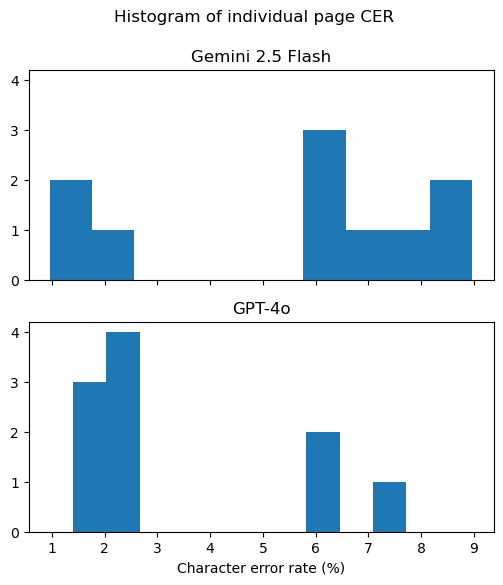

In [38]:
# Compare error rates of different models/methods
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True, sharey=True)
fig.suptitle('Histogram of individual page CER')
ax0.hist(cer_pct['gemini-2.5-flash'])
ax0.set_title('Gemini 2.5 Flash')
ax1.hist(cer_pct['gpt-4o'])
ax1.set_title('GPT-4o')
ax1.set_xlabel('Character error rate (%)')